In [ ]:
#default_exp drawgraph

# drawgraph

> Drawing graphs with graphviz.

In [ ]:
#export
from fastcore.all import *

import pydot
from matplotlib.colors import rgb2hex, hex2color

In [ ]:
#export
_all_ = ['pydot']

In [ ]:
#hide
from nbdev.showdoc import *

## Nodes

In [ ]:
#export
def Dot(defaults=None, rankdir='LR', directed=True, compound=True, **kwargs):
    "Create a `pydot.Dot` graph with fastai/fastgraph style defaults"
    return pydot.Dot(rankdir=rankdir, directed=directed, compound=compound, **kwargs)

In [ ]:
#export
def _uniq_name(): return 'n'+(uuid4().hex)

def quote(x, q='"'):
    'Surround `x` with `"`'
    return f'"{x}"'

@patch
def _repr_svg_(self:pydot.Dot):
    return self.create_svg().decode('utf-8')

In [ ]:
#export
def _pydot_create(f, label, **kwargs):
    kwargs = {k:v(label) if callable(v) else quote(v) for k,v in kwargs.items()}
    return f(_uniq_name(), label=quote(label), **kwargs)

In [ ]:
#export
node_defaults = dict(shape='box', style='rounded, filled', fillcolor='white')

In [ ]:
#export
def Node(label, tooltip=None, **kwargs):
    "Create a `pydot.Node` with a unique name"
    if not isinstance(label,str) and isinstance(label, Collection) and len(label)==2:
        label,tooltip = label
    kwargs = merge(node_defaults, kwargs)
    if tooltip is None: tooltip = label 
    return _pydot_create(pydot.Node, label, tooltip=tooltip, **kwargs)

`pydot` uses the same name-based approach to identifying graph items as `graphviz`. However we would rather use python objects. Therefore, we patch `pydot` to use unique names.

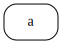

In [ ]:
g = Dot()
g.add_node(Node('a'))
g

If a 2-tuple is passed to `add_node`, then the 2nd element becomes the tooltip. You can also pass any `kwargs` that are accepted by `graphviz`.

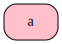

In [ ]:
g = Dot()
g.add_node(Node(['a', "My tooltip"], fillcolor='pink'))
g

Keyword args can also be arbitrary functions, which will called with the node's label.

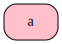

In [ ]:
g = Dot()
g.add_node(Node('a', fillcolor=lambda o:'pink'))
g

## Colors

The callable kwargs functionality can be used to map labels to colors in a consistent way..

In [ ]:
#export
def obj2node_color(cm, minalpha, rangealpha, o):
    "Create a consistent mapping from objects to colors, using colormap `cm`"
    h = hash(o)
    i = float(h % 256) / 256
    alpha = (h^hash('something')) % rangealpha + minalpha
    return rgb2hex(cm(i)) + f'{alpha:02X}'

In [ ]:
#exports
graph_colors1 = partial(obj2node_color, plt.get_cmap('gist_ncar'), 80, 80)
graph_colors2 = partial(obj2node_color, plt.get_cmap('Set3'), 60, 155)

These predefined color mapping functions provide a good range of colors and readable text.

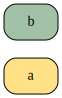

In [ ]:
g = Dot()
g.add_node(Node('a', fillcolor=graph_colors1))
g.add_node(Node('b', fillcolor=graph_colors1))
g

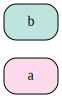

In [ ]:
g = Dot()
g.add_node(Node('a', fillcolor=graph_colors2))
g.add_node(Node('b', fillcolor=graph_colors2))
g

We'll use the former color function as our default. You can change it by simply modifying `node_defaults`.

In [ ]:
#export
node_defaults['fillcolor'] = graph_colors1

## Clusters and Items

In [ ]:
#export
def Cluster(label='', tooltip=None, style='rounded, filled', fillcolor='#55555522', **kwargs):
    "Create a `pydot.Cluster` with a unique name"
    if tooltip is None: tooltip = label 
    return _pydot_create(pydot.Cluster, label, tooltip=tooltip, style=style, fillcolor=fillcolor, **kwargs)

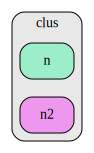

In [ ]:
g = Dot()
sg = Cluster('clus', tooltip='Cluster tooltip')
sg.add_node(Node(['n', "My tooltip"]))
sg.add_node(Node('n2'))
g.add_subgraph(sg)
g

In [ ]:
#export
@patch
def nodes(self:pydot.Graph):
    "`i`th node in `Graph`"
    return L(o for o in self.get_nodes() if o.get_label() is not None)

In [ ]:
#export
@patch
def __getitem__(self:pydot.Graph, i):
    "`i`th node in `Graph`"
    return self.nodes()[i]

You can subscript into a `Graph`'s `Node`s by index:

In [ ]:
print(sg[0].get_label())

"n"


In [ ]:
#export
@patch
def add_item(self:pydot.Graph, item, **kwargs):
    "Add a `Cluster`, `Node`, or `Edge` to the `Graph`"
    if not isinstance(item, (pydot.Edge,pydot.Node,pydot.Graph)): item = Node(item, **kwargs)
    f = self.add_node     if isinstance(item, pydot.Node ) else \
        self.add_subgraph if isinstance(item, pydot.Graph) else \
        self.add_edge     if isinstance(item, pydot.Edge ) else None
    f(item)
    return item

There's no good reason to have different methods for adding clusters vs nodes, so we provide a single method.

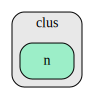

In [ ]:
g = Dot()
sg = Cluster('clus')
g.add_item(sg)
sg.add_item('n')
g

In [ ]:
#export
@patch
def add_items(self:pydot.Graph, *items, **kwargs):
    "Add `items` the `Graph`"
    return L(self.add_item(it, **kwargs) for it in items)

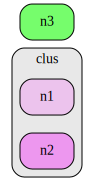

In [ ]:
sg = Cluster('clus')
sg.add_items('n1', 'n2')
g = Dot()
g.add_items(sg, 'n3')
g

## Edges

In [ ]:
#export
@patch
def first(self:pydot.Graph):
    "First node in `Graph`, searching subgraphs recursively as needed"
    nodes = self.nodes()
    if nodes: return nodes[0]
    for subg in self.get_subgraphs():
        res = subg.first()
        if res: return res

In [ ]:
#export
@patch
def last(self:pydot.Graph):
    "Lastt node in `Graph`, searching subgraphs recursively as needed"
    nodes = self.nodes()
    if nodes: return nodes[-1]
    for subg in reversed(self.get_subgraphs()):
        res = subg.last()
        if res: return res

In [ ]:
#export
@patch
def connect(self:(pydot.Node,pydot.Graph), item):
    "Connect two nodes or clusters"
    a,b,ltail,lhead = self,item,'',''
    if isinstance(self,pydot.Graph):
        a = self.last()
        ltail=self.get_name()
    if isinstance(item,pydot.Graph):
        b = item.first()
        lhead=item.get_name()
    return pydot.Edge(a, b, lhead=lhead, ltail=ltail)

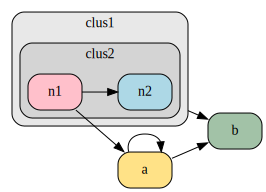

In [ ]:
sg2 = Cluster('clus2')
n1 = sg2.add_item('n1', fillcolor='pink')
n2 = sg2.add_item('n2', fillcolor='lightblue')
sg2.add_item(n1.connect(n2))

sg1 = Cluster('clus1')
sg1.add_item(sg2)

a,b = Node('a'),Node('b')
edges = a.connect(b),a.connect(a),sg1.connect(b),sg2[0].connect(a)
g = Dot()
g.add_items(sg1, a, b, *edges)
g

## Sequential

In [ ]:
#export
@patch
def seq_edges(self:pydot.Graph, items):
    "Add edges between each pair of nodes in `items`"
    return L(items[i].connect(items[i+1]) for i in range(len(items)-1))

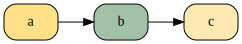

In [ ]:
g = Dot()
its = g.add_items('a','b','c')
g.add_items(*g.seq_edges(its))
g

In [ ]:
#export
def seq_cluster(items, cluster_label='', **kwargs):
    sg = Cluster(cluster_label)
    its = sg.add_items(*items, **kwargs)
    sg.add_items(*sg.seq_edges(its))
    return sg

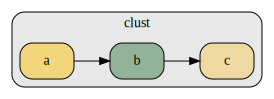

In [ ]:
g = Dot()
g.add_item(seq_cluster(['a','b','c'], 'clust'))
g

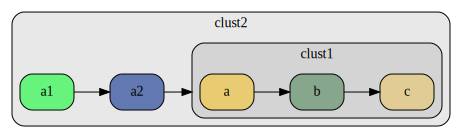

In [ ]:
sg1 = (seq_cluster(['a','b','c'], 'clust1'))
sg2 = (seq_cluster(['a1','a2',sg1], 'clust2'))
g = Dot()
g.add_items(sg2)
g

## Experiments with data structures

In [ ]:
#export
def draw_graph(graph, items=None):
    g = Dot()
    graph = L(graph)
    if items is None: items = L(set(graph.itemgot(0)+graph.itemgot(1)))
    nodes = g.add_items(*items)
    mapping = dict(zip(items,nodes))
    g.add_items(*[mapping[k].connect(mapping[v]) for k,v in graph])
    return g

In [ ]:
items = A,B,C,D = dict(a='Aa', b='Bb', c='Cc', d='Dd').items()
graph = L((A,B), (A,C), (B,D), (C,C))

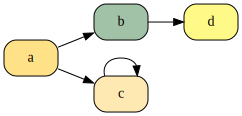

In [ ]:
draw_graph(graph)

In [ ]:
graph = {
    'a': (A, []),
    'b': (B, ['a']),
    'c': (C, {'x': 'a', 'y': 'c'}),
    'd': (D, ['b'])
}

# Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_drawgraph.ipynb.
Converted 00_pagegraph.ipynb.
Converted index.ipynb.
